In [1]:
#Importing Data from the CSV file
%matplotlib inline
import string
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd


f_train = open("training.1600000.processed.noemoticon.csv", "r", encoding="ISO-8859-1")
X_train = f_train.readlines()
f_test = open("testdata.manual.2009.06.14.csv", "r")
X_test = f_test.readlines()

#Creating the List with just the tweets and finding the number of positive and negative classes. (TRAINING) 
#class_0 = number of classes with label = 0
#class_4 = number of classes with label = 4

class_0=class_4=0
tweets_train =[]
for x in X_train:
    a = x.split('","')
    if (a[0] == '"0'): class_0+=1
    else: class_4+=1
    tweets_train.append('%s"|"%s' % (a[0],a[-1]))

#Creating the List with just the tweets (TEST DATA)
tweets_test =[]
for x in X_test:
    a = x.split('","')
    tweets_test.append('%s"|"%s' % (a[0], a[-1]))
    
print("The length of the training set is = ", len(X_train))
print("The number of classes (label=4) =", class_4)
print("The number of classes (label=0) =", class_0)
print("The length of the test set is = ", len(X_test))

f_test.close()
f_train.close()

m= len(X_train)
phi_0 = class_0/m
phi_4 = class_4/m

The length of the training set is =  1600000
The number of classes (label=4) = 800000
The number of classes (label=0) = 800000
The length of the test set is =  359


## Part(e)

[nltk_data] Downloading package stopwords to /home/ayushi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ayushi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
tweets_train_pd = pd.read_pickle('tweet_train_lemma.pkl')
tweets_test_pd = pd.read_pickle('tweet_test_lemma.pkl')
train_classes = pd.read_pickle('train_class.pkl')
test_actual_classes = pd.read_pickle('test_class.pkl')

In [4]:
#Create Dictionary
import time

def create_dict(tweets, train_classes):
    start = time.time()
    dictionary = {}
    dict_0 = {}
    dict_4 = {}
    n = []
    n_0 =[]
    n_4 = []
    for i in range(len(tweets)):
        x = tweets.get(i)
        n.append(len(x))
        if (train_classes.get(i) == '"0"'): n_0.append(len(x)) 
        else: n_4.append(len(x))
            
        for w in x:
    #Global Vocabulary
            if w in dictionary:
                dictionary[w]+=1
            else:
                dictionary[w]=1
    #build Vocabulary for class 0 (-ve class)
            if (train_classes.get(i) == '"0"'):
                if w in dict_0:
                    dict_0[w]+=1
                else:
                    dict_0[w]=1
    #build Vocabulary for class 4 (+ve class)
            else:
                if w in dict_4:
                    dict_4[w]+=1
                else:
                    dict_4[w]=1

    end = time.time()                
    print("Time to Create Dictionary =", end-start)
    return dictionary, dict_0, dict_4, n, n_0, n_4;

In [5]:
def train_nb_classifier(dictionary, dict_0, dict_4, len_tweets, n_0, n_4, class_0, class_4):
    v = len(dictionary)
    theta_0 = {}
    theta_4 = {}
    n_0 = sum(n_0) # Sum of all the length of the tweets in class 0
    n_4 = sum(n_4) # Sum of all the length of the tweets in class 0
    c=1
    for word in dictionary.keys():
            if word in dict_0:
                theta_0[word] = ((dict_0[word]+c)/(n_0 + v*c))
            else:
                theta_0[word] = ((c) / (n_0 + v*c))
            if word in dict_4:
                theta_4[word] = ((dict_4[word]+c)/(n_4 + v*c))
            else:
                theta_4[word] = ((c)/(n_4 + v*c))
    return theta_0,theta_4;

In [6]:
def test_data(tweets, theta_0, theta_4, actual_classes, phi_0, phi_4):
    pred_class=[]
    #actual_class=[]
    for x in tweets:
        test_class0=test_class4=0
        
        #Finding probability of tweet being in a class         
        for w in x:
            if w in theta_0: test_class0 += math.log(theta_0[w])
            else: test_class0 += math.log(1)
            if w in theta_4: test_class4 += math.log(theta_4[w])
            else: test_class4 += math.log(1)
        test_class0 += math.log(phi_0)
        test_class4 += math.log(phi_4)
        #Classifying the probability into classes
        if (test_class0 > test_class4): pred_class.append(0)
        else: pred_class.append(1)

    actual_class = actual_classes.apply(lambda x: 0 if x=='"0"' else 1).tolist()
    test_error = sum(np.bitwise_xor(actual_class, pred_class))
    accuracy = ((len(tweets) - test_error)/len(tweets))*100
    return accuracy, actual_class, pred_class;

In [15]:
dictionary_raw, dict_0_raw, dict_4_raw, len_tweets, len_tweets_0, len_tweets_4 = create_dict(tweets_train_pd, train_classes)

Time to Create Dictionary = 239.9823281764984


In [82]:
f = open("dictionary_raw.pkl","wb")
pickle.dump(dictionary_raw,f)
f.close()

f = open("dict_0.pkl", "wb")
pickle.dump(dict_0_raw, f)
f.close()

f = open("dict_4.pkl", "wb")
pickle.dump(dict_4_raw, f)
f.close()


In [10]:
dictionary_raw = pd.read_pickle("dictionary_raw.pkl")
dict_0_raw = pd.read_pickle("dict_0.pkl")
dict_4_raw = pd.read_pickle("dict_4.pkl")


Text(0, 0.5, 'No of words')

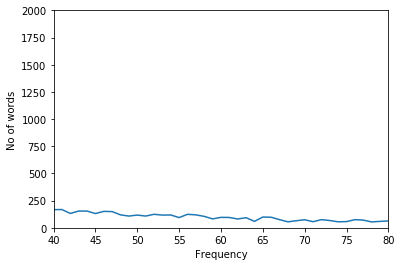

In [11]:
nw = [0 for i in range(max(dictionary_raw.values())+1)] 
f = [i for i in range(max(dictionary_raw.values())+1)] 
for key in dictionary_raw:
    nw[dictionary_raw[key]]+=1
plt.plot(f,nw)
plt.axis([40, 80, 0, 2000])
plt.xlabel("Frequency")
plt.ylabel("No of words")
#plt.show()

In [12]:
# (1) Feature - We see that the number of words with very less frequency is very high. So we can actually 
# Discard those words since they will not play much role in deciding the class of a tweet
# This would be for words like numbers, or language specific words like muera, wrong spelling words, etc. 
# We don't need to modify dict_0 and dict_4 since they will only be accessed for words found in the global
# dictionary 

cutoff_freq = 0 #40 is the optimum for 83% accuracy
n_cutoff = len(dictionary_raw)-sum(nw[0:cutoff_freq]) 
print("Number of words with frequency higher than cutoff frequency({}) :".format(cutoff_freq),n_cutoff)

Number of words with frequency higher than cutoff frequency(0) : 282344


In [13]:
dictionary_raw_new = {}
for key in dictionary_raw:
    if dictionary_raw[key] >=cutoff_freq:
        dictionary_raw_new[key]=dictionary_raw[key]

In [16]:
theta_0_raw, theta_4_raw = train_nb_classifier(dictionary_raw_new, dict_0_raw, dict_4_raw, len_tweets, len_tweets_0, len_tweets_4, class_0, class_4)

In [17]:
train_accuracy,actual_class_train,pred_class_train = test_data(tweets_train_pd, theta_0_raw, theta_4_raw, train_classes, phi_0, phi_4)
print("Result (a) : The train accuracy of the model on raw data is = {}%".format(train_accuracy))

Result (a) : The train accuracy of the model on raw data is = 79.256625%


In [18]:
test_accuracy, actual_class,pred_class = test_data(tweets_test_pd, theta_0_raw, theta_4_raw, test_actual_classes, phi_0, phi_4)
print("Result (a) : The test accuracy of the model on raw data is = {}%".format(test_accuracy))

Result (a) : The test accuracy of the model on raw data is = 80.50139275766016%


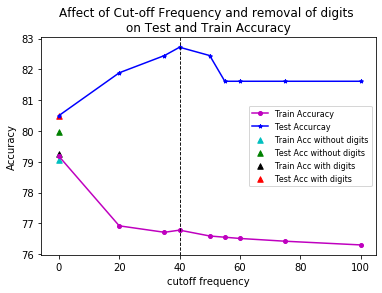

In [15]:
#Effect of cutoff-frequency on Train and Test Accuracy without bigrams
cutoff = [0, 20, 35, 40, 50, 55, 60, 75, 100]
train_acc = [79.18, 76.92, 76.71,76.78,76.59,76.55,76.51,76.42,76.30]
test_acc = [80.50, 81.89, 82.45, 82.72, 82.45, 81.615, 81.615, 81.615, 81.615]
plt.plot(cutoff, train_acc, marker='o', markersize=4, c='m', label='Train Accuracy')
plt.plot(cutoff, test_acc, marker='*', markersize=4, c='b', label ='Test Accurcay')
plt.axvline(x=40, c='k', linestyle='--', linewidth=0.9)
plt.scatter(0,79.07, marker='^', s=30, c='c', label='Train Acc without digits')
plt.scatter(0,79.97, marker='^', s=30, c='g', label='Test Acc without digits')
plt.scatter(0,79.25, marker='^', s=30, c='k', label='Train Acc with digits')
plt.scatter(0,80.50, marker='^', s=30, c='r', label='Test Acc with digits')
/
plt.xlabel("cutoff frequency")
plt.ylabel("Accuracy")
plt.legend(fontsize=8)
plt.title("Affect of Cut-off Frequency and removal of digits \non Test and Train Accuracy")
#plt.savefig("cutoff_accuracy.png",dpi=1000, bbox_inches='tight')
plt.show()

In [19]:
import itertools 

tweets_test =tweets_test_pd.apply(lambda x: list(map(list, zip(x, x[1:]))))
tweets_test['bigrams_str']=tweets_test.apply(lambda x: [' '.join(x[i]) for i in range(len(x))])

In [20]:
tweets_train=tweets_train_pd.apply(lambda x: list(map(list, zip(x, x[1:]))))
tweets_train['bigrams_str']=tweets_train.apply(lambda x: [' '.join(x[i]) for i in range(len(x))])

In [37]:
dictionary_bigrams_1, dict_0_bigrams, dict_4_bigrams, len_bigrams, len_bigrams_0, len_bigrams_4 = create_dict(tweets_train['bigrams_str'], train_classes)

Time to Create Dictionary = 232.9731945991516


In [83]:
f = open("dictionary_bigrams.pkl","wb")
pickle.dump(dictionary_bigrams_1,f)
f.close()

f = open("dict_0_bigrams.pkl", "wb")
pickle.dump(dict_0_bigrams, f)
f.close()

f = open("dict_4_bigrams.pkl", "wb")
pickle.dump(dict_4_bigrams, f)
f.close()


In [48]:
dictionary_bigrams_1 = pd.read_pickle("dictionary_bigrams.pkl")
dict_0_bigrams = pd.read_pickle("dict_0_bigrams.pkl")
dict_4_bigrams = pd.read_pickle("dict_4_bigrams.pkl")


Text(0, 0.5, 'No of words')

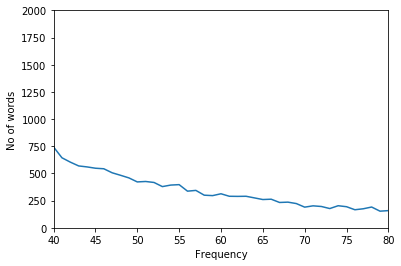

In [49]:
nw = [0 for i in range(max(dictionary_bigrams_1.values())+1)] 
f = [i for i in range(max(dictionary_bigrams_1.values())+1)] 
for key in dictionary_bigrams_1:
    nw[dictionary_bigrams_1[key]]+=1
plt.plot(f,nw)
plt.axis([40, 80, 0, 2000])
plt.xlabel("Frequency")
plt.ylabel("No of words")
#plt.show()

In [50]:
# (2) Using BIGRAMS - only consecutive words
# We don't need to modify dict_0 and dict_4 since they will only be accessed for words found in the global
# dictionary 

cutoff_freq = 50
n_cutoff = len(dictionary_bigrams_1)-sum(nw[0:cutoff_freq]) 
print("Number of words with frequency higher than cutoff frequency({}) :".format(cutoff_freq),n_cutoff)

Number of words with frequency higher than cutoff frequency(50) : 18937


In [51]:
dictionary_bigrams_new = {}
for key in dictionary_bigrams_1:
    if dictionary_bigrams_1[key] >=cutoff_freq:
        dictionary_bigrams_new[key]=dictionary_bigrams_1[key]

In [52]:
len(dict_4_bigrams)

2238405

In [53]:
dictionary_bigrams_new.update(dictionary_raw_new)
dict_0_bigrams.update(dict_0_raw)
dict_4_bigrams.update(dict_4_raw)

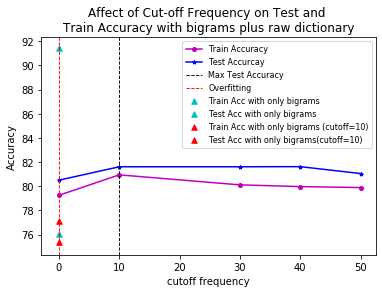

In [65]:
#Effect of cutoff-frequency on Train and Test Accuracy - Raw Dictionary+Bigrams
cutoff = [0, 10, 30, 40, 50]
train_acc = [79.25, 80.94, 80.112, 79.97, 79.89]
test_acc =  [80.50, 81.61, 81.61, 81.62, 81.05]
plt.plot(cutoff, train_acc, marker='o', markersize=4, c='m', label='Train Accuracy')
plt.plot(cutoff, test_acc, marker='*', markersize=4, c='b', label ='Test Accurcay')
plt.axvline(x=10, c='k', linestyle='--', linewidth=0.9, label='Max Test Accuracy')
plt.axvline(x=0, c='r', linestyle='--', linewidth=0.9, label='Overfitting')
plt.scatter(0,91.468, marker='^', s=30, c='c', label='Train Acc with only bigrams')
plt.scatter(0,76.02, marker='^', s=30, c='c', label='Test Acc with only bigrams')
plt.scatter(0,75.36, marker='^', s=30, c='r', label='Train Acc with only bigrams (cutoff=10)')
plt.scatter(0,77.15, marker='^', s=30, c='r', label='Test Acc with only bigrams(cutoff=10)')

plt.xlabel("cutoff frequency")
plt.ylabel("Accuracy")
plt.legend(fontsize=8)
plt.title("Affect of Cut-off Frequency on Test and \nTrain Accuracy with bigrams plus raw dictionary")
plt.savefig("Accuracy_with_Bigrams_and_Raw.png",dpi=1000, bbox_inches='tight')
plt.show()

In [54]:
theta_0_bigrams, theta_4_bigrams = train_nb_classifier(dictionary_bigrams_new, dict_0_bigrams, dict_4_bigrams, len_tweets, len_tweets_0, len_tweets_4, class_0, class_4)

In [55]:
train_accuracy,actual_class_train,pred_class_train = test_data(tweets_train_pd+tweets_train['bigrams_str'], theta_0_bigrams, theta_4_bigrams, train_classes, phi_0, phi_4)
print("Result (a) : The train accuracy of the model on raw data is = {}%".format(train_accuracy))

Result (a) : The train accuracy of the model on raw data is = 79.89387500000001%


In [56]:
test_accuracy, actual_class,pred_class = test_data((tweets_test_pd+tweets_test['bigrams_str']), theta_0_bigrams, theta_4_bigrams, test_actual_classes, phi_0, phi_4)
print("Result (a) : The test accuracy of the model on raw data is = {}%".format(test_accuracy))

Result (a) : The test accuracy of the model on raw data is = 81.05849582172702%
